In [1]:
# imports 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as anndata
import seaborn as sbn
import matplotlib.pyplot as plt
from mango import Tuner, scheduler

In [2]:
# read data
adata = sc.read_h5ad('Group_7.h5ad')
adata

AnnData object with n_obs × n_vars = 34957 × 32738
    obs: 'cell-types'
    var: 'gene_ids'

In [3]:
# map to a generic cell type mapping
cell_type_mapping = {
    'CD8+/CD45RA+ Naive Cytotoxic': 'T cell',
    'CD14+ Monocyte': 'Monocyte',
    'CD56+ NK': 'NK cell',
    'CD19+ B': 'B cell',
}
adata.obs['cell-types'] = adata.obs['cell-types'].map(cell_type_mapping)

In [4]:
# calculate QC metrics
# Identify mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Identify ribosomal genes (replace 'RPS' and 'RPL' with the actual prefixes used in your dataset)
adata.var['rb'] = adata.var_names.str.startswith(('RPS', 'RPL'))

# Calculate QC metrics for both mitochondrial and ribosomal genes
sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt', 'rb'], percent_top=None, log1p=False, inplace=True)

The number of outlier cells is:  4040
Number of cells after filtering cells:  30874


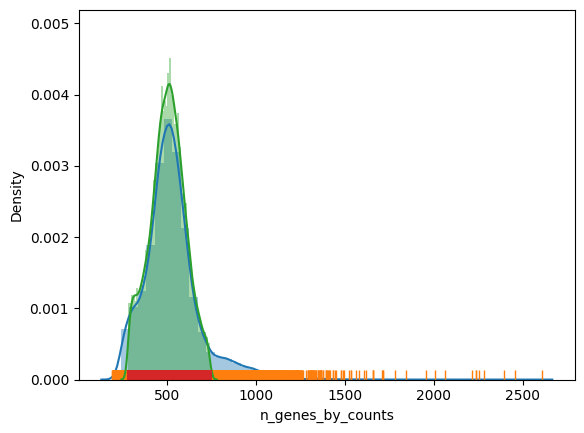

In [5]:
# preprocess, calculate and filter genes, normalize and scale data, 
# total genes detected in each cell
total_genes_per_cells = adata.obs['n_genes_by_counts']

median_genes = np.median(total_genes_per_cells)

# Calculate MAD
mad_genes = np.median(np.abs(total_genes_per_cells - median_genes))

# Define lower and upper bounds
lower_bound = median_genes - 3 * mad_genes
upper_bound = median_genes + 3 * mad_genes

# Identify outlier cells
outlier_cells = np.sum((total_genes_per_cells < lower_bound)
                       | (total_genes_per_cells > upper_bound))

print("The number of outlier cells is: ", outlier_cells)
# Before filtering cells
sbn.distplot(adata.obs.n_genes_by_counts)
sbn.rugplot(adata.obs.n_genes_by_counts)
# After filtering cells
adata_filtered = adata[adata.obs.n_genes_by_counts > lower_bound, :]
adata_filtered = adata_filtered[adata_filtered.obs.n_genes_by_counts < upper_bound, :]
print('Number of cells after filtering cells: ', adata_filtered.shape[0])

# Check the effect of data preprocessing, notice the change to the normal distribution
sbn.distplot(adata_filtered.obs.n_genes_by_counts)
sbn.rugplot(adata_filtered.obs.n_genes_by_counts)
sc.pp.filter_genes(adata_filtered, min_cells=3)
sc.pp.normalize_total(adata_filtered, target_sum=None, inplace=True)
sc.pp.log1p(adata_filtered)
sc.pp.highly_variable_genes(
    adata_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata_filtered)
sc.tl.pca(adata_filtered, svd_solver='arpack')
sc.pp.neighbors(adata_filtered, n_neighbors=15, n_pcs=40)
# Embedding the neighborhood graph
sc.tl.umap(adata_filtered)

In [6]:
# extract X and y
X = adata_filtered.obsm["X_umap"]  # features (PCA components)
y = adata_filtered.obs['cell-types']  # labels (cell types)

In [7]:
# encode labels
encoder = LabelEncoder()
y_labels = encoder.fit_transform(y)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_labels, test_size=0.3, random_state=42)

In [8]:
# uncomment to tune hyperparameters and perform k fold

# param_space = dict(min_samples_split=range(2, 10), n_estimators=range(75, 120), min_samples_leaf=range(
#     1, 10), max_features=["sqrt", "log2", None], criterion=["gini", "entropy"])


# @scheduler.serial
# def objective(**params):
#     clf = RandomForestClassifier(**params)
#     score = cross_val_score(clf, X_train, y_train, cv=10).mean()
#     return score


# tuner = Tuner(param_space, objective, {'num_iteration': 25})
# results = tuner.maximize()
# print('best parameters:', results['best_params'])
# print('best accuracy:', results['best_objective'])

In [9]:
# fit the model with the best parameters
# params = results['best_params']
params ={'n_estimators': 85, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini'}

# or hardcode the best parameters
clf_scrna = RandomForestClassifier(criterion=params['criterion'], max_features=params['max_features'],
                                      min_samples_leaf=params['min_samples_leaf'], min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'])
clf_scrna.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=7, n_estimators=85)

In [10]:
# prediction
y_pred = clf_scrna.predict(X_test)
print("Accuracy Score", accuracy_score(y_test, y_pred))
print("F1 Score", f1_score(y_test, y_pred,average='macro'))

Accuracy Score 0.9980567850588362
F1 Score 0.9973778951871353


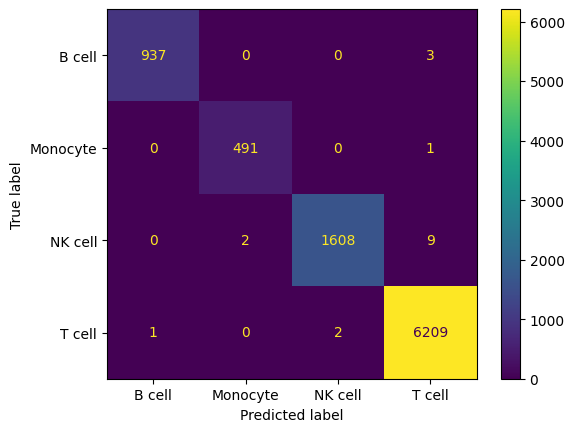

In [12]:
labels = list(encoder.classes_)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

In [13]:
# run for test data
test_adata = sc.read_h5ad('Test_dataset.h5ad')

The number of outlier cells is:  5639
Number of cells after filtering cells:  40137


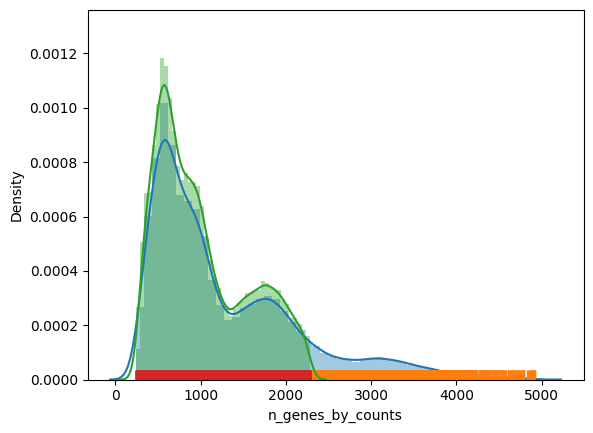

In [14]:
# perform filtering and preprocessing

test_adata.var['mt'] = test_adata.var_names.str.startswith('MT-')

# Identify ribosomal genes (replace 'RPS' and 'RPL' with the actual prefixes used in your dataset)
test_adata.var['rb'] = test_adata.var_names.str.startswith(('RPS', 'RPL'))

# Calculate QC metrics for both mitochondrial and ribosomal genes
sc.pp.calculate_qc_metrics(
    test_adata, qc_vars=['mt', 'rb'], percent_top=None, log1p=False, inplace=True)
total_genes_per_cells = test_adata.obs['n_genes_by_counts']

median_genes = np.median(total_genes_per_cells)

# Calculate MAD
mad_genes = np.median(np.abs(total_genes_per_cells - median_genes))

# Define lower and upper bounds
lower_bound = median_genes - 3 * mad_genes
upper_bound = median_genes + 3 * mad_genes

# Identify outlier cells
outlier_cells = np.sum((total_genes_per_cells < lower_bound)
                       | (total_genes_per_cells > upper_bound))

print("The number of outlier cells is: ", outlier_cells)

# Before filtering cells
sbn.distplot(test_adata.obs.n_genes_by_counts)
sbn.rugplot(test_adata.obs.n_genes_by_counts)
# After filtering cells
test_adata_filtered = test_adata[test_adata.obs.n_genes_by_counts > lower_bound, :]
test_adata_filtered = test_adata_filtered[test_adata_filtered.obs.n_genes_by_counts < upper_bound, :]
print('Number of cells after filtering cells: ', test_adata_filtered.shape[0])

# Check the effect of data preprocessing, notice the change to the normal distribution
sbn.distplot(test_adata_filtered.obs.n_genes_by_counts)
sbn.rugplot(test_adata_filtered.obs.n_genes_by_counts)

sc.pp.filter_genes(test_adata_filtered, min_cells=3)

In [15]:
# map cell tyes in test data to generic cell types
cell_types_to_filter = ['NK cell', 'B cell', 'CD8+ T cell', 'CD14+ Monocyte',
                        'CD4+ T cell', 'CD16+ Monocyte', 'Plasmablast', 'Other T']
mask = test_adata_filtered.obs['cell-types'].isin(cell_types_to_filter)
test_adata_filtered = test_adata_filtered[mask]

cell_type_mapping = {
    'CD8+ T cell': 'T cell',
    'CD4+ T cell': 'T cell',
    'Other T': 'T cell',
    'CD14+ Monocyte': 'Monocyte',
    'CD16+ Monocyte': 'Monocyte',
    'NK cell': 'NK cell',
    'B cell': 'B cell',
    'Plasmablast': 'B cell'
}

test_adata_filtered.obs['cell-types'] = test_adata_filtered.obs['cell-types'].map(
    cell_type_mapping)

In [16]:
X_unseen = test_adata_filtered.obsm["X_umap"]  # features (PCA components)
y_unseen = test_adata_filtered.obs['cell-types']  # labels (cell types)
y_label_unseen = encoder.transform(y_unseen)

In [17]:
# predict on unseen data
y_unseen_pred = clf_scrna.predict(X_unseen)

# Calculate Accuracy
accuracy = accuracy_score(y_label_unseen, y_unseen_pred)
print(f'Accuracy: {accuracy}')

# Calculate F1 Score
f1 = f1_score(y_label_unseen, y_unseen_pred, average='macro')
print(f'F1 Score: {f1}')

Accuracy: 0.3933863711460743
F1 Score: 0.25347213241258904


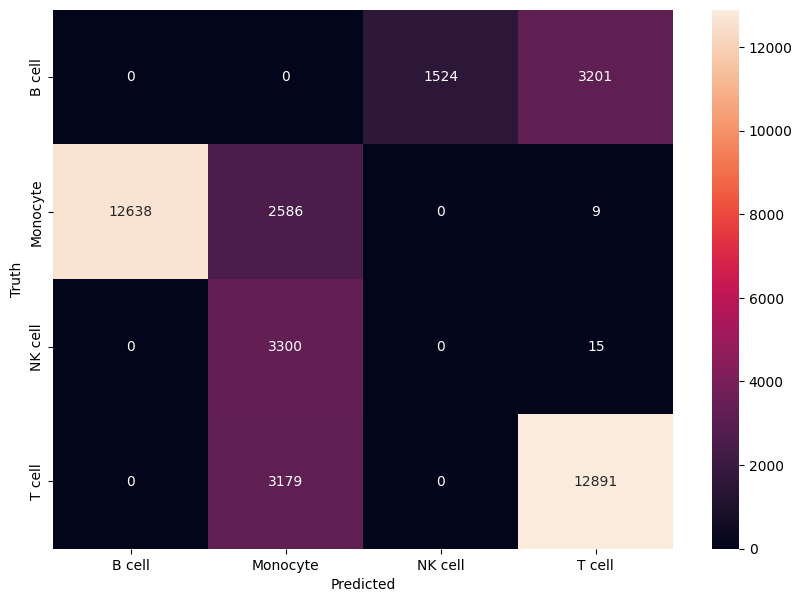

In [18]:
labels = list(encoder.classes_)

cm = confusion_matrix(y_label_unseen, y_unseen_pred,)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sbn.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()